# The Random Chili Peppers

This example is based on a puzzle of [FiveThirtyEight](https://fivethirtyeight.com/features/how-fast-can-you-skip-to-your-favorite-song/).

We assume we have a music player containing $N = 100$ songs.
We can switch songs through two buttons: either going to the *next* or a *random* song.
Starting at any song, we want to reach our favourite song at position $42$ as fast as possible.

## Initialization
Before starting the analysis, we first have to load the stormpy library. We also output the Storm and stormpy versions used.

In [1]:
import stormpy
import stormpy.info

print("Stormpy version: " + stormpy.__version__)
print("using Storm in version: " + stormpy.info.storm_version())

Stormpy version: 1.8.0
using Storm in version: 1.8.0


## The model.
![MDP model](music_shuffle_model.png)
We model the music player by an MDP as depicted in the image above.
A state $k$ represents the song which currently plays. From each state, two choices are possible. Choice $n$ leads to the next song $k + 1$ with probability $1$. Choice $r$ randomly chooses a next song with a uniform probability distribution of $\frac{1}{N}$.

We specified the MDP model in the [Prism language](https://www.prismmodelchecker.org/manual/ThePRISMLanguage/Introduction). The Prism model can be found in the file `music_shuffle.nm`.

In [2]:
!cat music_shuffle.nm

// Find music track on shuffle player

mdp

// constants
const int N=100; // Number of tracks
const int K=42;  // Track to find

module search

	initial : bool init false;
	cur : [0..N-1] init 0;

	[] (!initial) -> 1/N : (cur'=0) & (initial'=true)
                       + 1/N : (cur'=1) & (initial'=true)
                       + 1/N : (cur'=2) & (initial'=true)
                       + 1/N : (cur'=3) & (initial'=true)
                       + 1/N : (cur'=4) & (initial'=true)
                       + 1/N : (cur'=5) & (initial'=true)
                       + 1/N : (cur'=6) & (initial'=true)
                       + 1/N : (cur'=7) & (initial'=true)
                       + 1/N : (cur'=8) & (initial'=true)
                       + 1/N : (cur'=9) & (initial'=true)
                       + 1/N : (cur'=10) & (initial'=true)
                       + 1/N : (cur'=11) & (initial'=true)
                       + 1/N : (cur'=12) & (initial'=true)
                       + 1/N : (cur'=13) & (initial'=

Using stormpy, we parse the model from the file.
Afterwards, we can for example check that the model type is an `MDP` as expected.

In [3]:
prism_program = stormpy.parse_prism_program("music_shuffle.nm")
print(prism_program.model_type)

PrismModelType.MDP


Next, we build the MDP model from the Prism file.
For better readability, we incorporate the *state valuations* (all variable values) and the *choice labels* (the names of the choices/actions) into the model.
After building the model, we can output some model statistics such as the number of states and transitions.

In [4]:
options = stormpy.BuilderOptions(True, True)
options.set_build_state_valuations()
options.set_build_choice_labels()
model = stormpy.build_sparse_model_with_options(prism_program, options)
print("Number of states: {}".format(model.nr_states))
print("Number of transitions: {}".format(model.nr_transitions))

Number of states: 101
Number of transitions: 10200


Stormpy allows us to explore the model in more detail.
For instance, we can select a specific state and output the corresponding values of the variables.

In [5]:
state = model.states[2]
state_vals = model.state_valuations
print("State {} with variable values: {}".format(state, state_vals.get_string(state.id)))

State 2 with variable values: [initial	& cur=1]


Furthermore, we can output all possible choices/actions and corresponding transitions from this state.

In [6]:
choice_labels = model.choice_labeling
for action in state.actions:
    for transition in action.transitions:
        action_index = model.transition_matrix.get_row_group_start(state.id) + action.id
        print("With choice {} and probability {}, go to state {} {}".format(choice_labels.get_labels_of_choice(action_index), transition.value(), transition.column, state_vals.get_string(transition.column)))
        if transition.column > 10: break

With choice {'next'} and probability 1.0, go to state 3 [initial	& cur=2]
With choice {'shuffle'} and probability 0.01, go to state 1 [initial	& cur=0]
With choice {'shuffle'} and probability 0.01, go to state 2 [initial	& cur=1]
With choice {'shuffle'} and probability 0.01, go to state 3 [initial	& cur=2]
With choice {'shuffle'} and probability 0.01, go to state 4 [initial	& cur=3]
With choice {'shuffle'} and probability 0.01, go to state 5 [initial	& cur=4]
With choice {'shuffle'} and probability 0.01, go to state 6 [initial	& cur=5]
With choice {'shuffle'} and probability 0.01, go to state 7 [initial	& cur=6]
With choice {'shuffle'} and probability 0.01, go to state 8 [initial	& cur=7]
With choice {'shuffle'} and probability 0.01, go to state 9 [initial	& cur=8]
With choice {'shuffle'} and probability 0.01, go to state 10 [initial	& cur=9]
With choice {'shuffle'} and probability 0.01, go to state 11 [initial	& cur=10]


We see that the model behaves as expected.
From the state $k$, we have the choice `next` which transitions to the next state $k+1$.
Alternatively, we use choice `shuffle` which randomly selects a next state. Each state then has a probability of $\frac{1}{N}$ which comes out to $0.01$ in our example.

## Labels
Before we start our analysis, we first label the states we are interested in. In our case we are interested in reaching a state where the song at position $42$ is played. We label such a state with `found`.
When printing all labels of the model, we see that `found` is indeed one of the labels.

In [7]:
print("Labels: {}".format(model.labeling.get_labels()))

Labels: {'found', 'deadlock', 'init', 'avoid'}


We can print all states which have the label `found` and see that indeed the song at position $42$ is labelled accordingly.

In [8]:
for state_index in model.labeling.get_states("found"):
    state = model.states[state_index]
    state_vals = model.state_valuations
    print("State {} with variable values: {}".format(state, state_vals.get_string(state.id)))

State 42 with variable values: [initial	& cur=41]


## Analysis

In our analysis, we want to compute the minimal expected number of button presses to reach our favourite song at position $42$ from any possible starting position.
Using stormpy, we compute the minimal expected number of steps to reach the label `found` (corresponding to state $42$).
This can be expressed by the property `Rmin=? [F "found"]`.
We refer to the [documentation](https://www.prismmodelchecker.org/manual/PropertySpecification/Introduction) for details on property specification.

We set the property in stormpy and perform the model checking for our model and our property of interest.

In [9]:
# Set property
formula_str = 'Rmin=? [F "found"]'
properties = stormpy.parse_properties(formula_str, prism_program)
# Model checking
result = stormpy.model_checking(model, properties[0])

By iterating over the result, we print the minimal expected number of button presses for each starting position.

In [10]:
# Print results for all states
i = 0
for res in result.get_values():
    print("Result for state {} {}: {}".format(i, state_vals.get_string(i), res))
    i += 1

Result for state 0 [!initial	& cur=0]: 12.642880448519954
Result for state 1 [initial	& cur=0]: 13.642880527567566
Result for state 2 [initial	& cur=1]: 13.642880606883292
Result for state 3 [initial	& cur=2]: 13.642880686468038
Result for state 4 [initial	& cur=3]: 13.642880766322717
Result for state 5 [initial	& cur=4]: 13.642880846448247
Result for state 6 [initial	& cur=5]: 13.642880926845544
Result for state 7 [initial	& cur=6]: 13.64288100751553
Result for state 8 [initial	& cur=7]: 13.64288108845913
Result for state 9 [initial	& cur=8]: 13.642881169677276
Result for state 10 [initial	& cur=9]: 13.642881251170893
Result for state 11 [initial	& cur=10]: 13.642881332940918
Result for state 12 [initial	& cur=11]: 13.64288141498829
Result for state 13 [initial	& cur=12]: 13.642881497313947
Result for state 14 [initial	& cur=13]: 13.642881579918837
Result for state 15 [initial	& cur=14]: 13.642881662803903
Result for state 16 [initial	& cur=15]: 13.642881745970096
Result for state 17 

We visualize the result below.

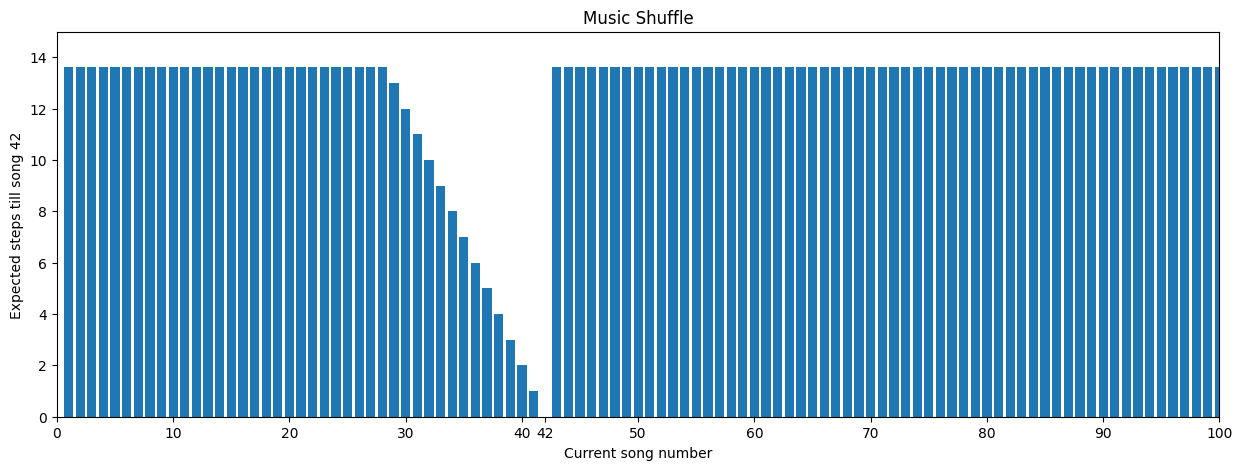

In [18]:
# Use matplotlib
import matplotlib.pyplot as plt

# Initialize plot
plt.rcParams["figure.figsize"] = (15,5)
plt.axis([1, 100, 0, 15])
plt.xticks(list(range(0,101,10)) + [42])
plt.xlabel('Current song number')
plt.ylabel('Expected steps till song 42')
plt.title("Music Shuffle")

# Plot results for all states
plt.bar(range(1,101), result.get_values()[1:]);

From the analysis result, we see that for most starting positions, we need $13.64$ steps to reach our favourite song. For the starting positions 29–42, a lower number of steps can be achieved.

## Optimal policy
By extracting the optimal policy via stormpy, we know which button (`next` or `shuffle`) should be pressed for each song position.

We set the argument `extract_scheduler` during the model checking call such that the optimal scheduler/policy is generated.
Afterwards, we can extract the optimal choice for each state.

In [12]:
result = stormpy.model_checking(model, properties[0], extract_scheduler=True)
scheduler = result.scheduler

buttons = dict()
for state in model.states:
    choice = scheduler.get_choice(state)
    choice = choice.get_deterministic_choice()
    action_index = model.transition_matrix.get_row_group_start(state.id) + choice
    buttons[state.id] = choice
    print("In state {} {} choose {}".format(state.id, state_vals.get_string(state.id), model.choice_labeling.get_labels_of_choice(action_index)))
print()

In state 0 [!initial	& cur=0] choose set()
In state 1 [initial	& cur=0] choose {'shuffle'}
In state 2 [initial	& cur=1] choose {'shuffle'}
In state 3 [initial	& cur=2] choose {'shuffle'}
In state 4 [initial	& cur=3] choose {'shuffle'}
In state 5 [initial	& cur=4] choose {'shuffle'}
In state 6 [initial	& cur=5] choose {'shuffle'}
In state 7 [initial	& cur=6] choose {'shuffle'}
In state 8 [initial	& cur=7] choose {'shuffle'}
In state 9 [initial	& cur=8] choose {'shuffle'}
In state 10 [initial	& cur=9] choose {'shuffle'}
In state 11 [initial	& cur=10] choose {'shuffle'}
In state 12 [initial	& cur=11] choose {'shuffle'}
In state 13 [initial	& cur=12] choose {'shuffle'}
In state 14 [initial	& cur=13] choose {'shuffle'}
In state 15 [initial	& cur=14] choose {'shuffle'}
In state 16 [initial	& cur=15] choose {'shuffle'}
In state 17 [initial	& cur=16] choose {'shuffle'}
In state 18 [initial	& cur=17] choose {'shuffle'}
In state 19 [initial	& cur=18] choose {'shuffle'}
In state 20 [initial	& cur

Again, we can visualize the results.

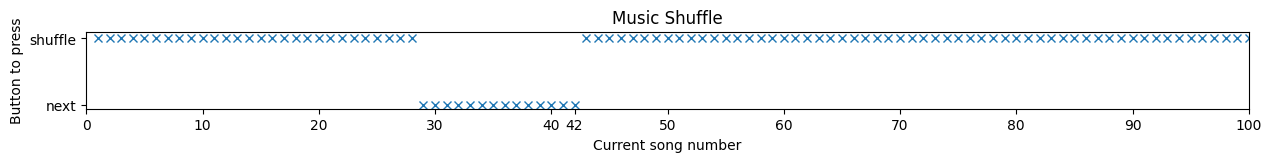

In [29]:
# Initialize plot
plt.rcParams["figure.figsize"] = (15,1)
plt.axis([0, 100, -0.05, 1.1])
plt.xticks(list(range(0,101,10)) + [42])
plt.yticks([0,1], ["next", "shuffle"])
plt.xlabel('Current song number')
plt.ylabel('Button to press')
plt.title("Music Shuffle")

# Plot optimal buttons
x, y = zip(*buttons.items())
plt.plot(x[1:], y[1:], 'x', linewidth=2);

We see that for songs 29–41, the optimal policy is to press the `next` button, for song 42 we have reached the goal, and for all other songs it is best to randomly choose the next song via `shuffle`.